# Feature importance

In this notebook, we will detail methods to investigate the importance of
features used by a given model. We will look at:

1. interpreting the coefficients in a linear model;
2. the attribute `feature_importances_` in RandomForest;
3. `permutation feature importance`, which is an inspection technique that
   can be used for any fitted model.

## 0. Presentation of the dataset

This dataset is a record of neighborhoods in California district, predicting
the **median house value** (target) given some information about the
neighborhoods, as the average number of rooms, the latitude, the longitude or
the median income of people in the neighborhoods (block).

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

X, y = fetch_california_housing(as_frame=True, return_X_y=True)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


The feature reads as follow:
- MedInc median income in block
- HouseAge median house age in block
- AveRooms average number of rooms
- AveBedrms average number of bedrooms
- Population block population
- AveOccup average house occupancy
- Latitude house block latitude
- Longitude house block longitude
- MedHouseVal Median house value in 100k$ *(target)*

To assert the quality of our inspection technique, let's add some random
feature that won't help the prediction (un-informative feature)

In [2]:
import numpy as np

# Adding random features
rng = np.random.RandomState(0)
bin_var = pd.Series(rng.randint(0, 1, X.shape[0]), name='rnd_bin')
num_var = pd.Series(np.arange(X.shape[0]), name='rnd_num')
X_with_rnd_feat = pd.concat((X, bin_var, num_var), axis=1)

We will split the data into training and testing for the remaining part of
this notebook

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_with_rnd_feat, y,
                                                    random_state=29)

Let's quickly inspect some features and the target

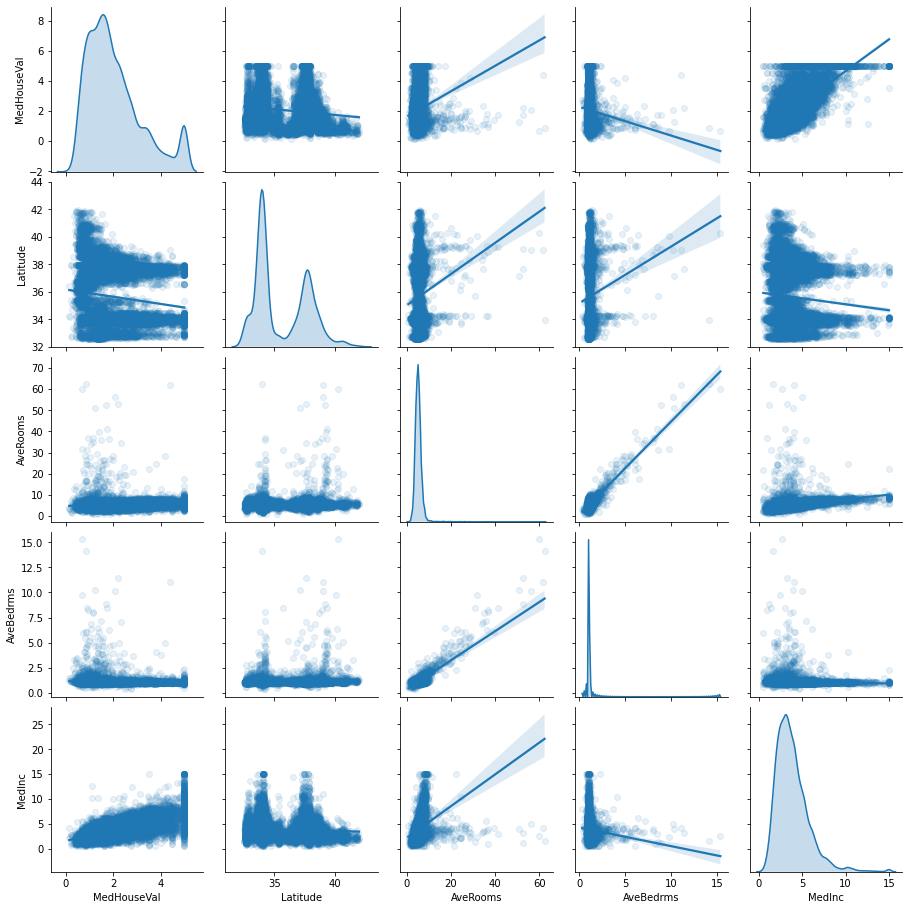

In [4]:
import seaborn as sns

train_dataset = X_train.copy()
train_dataset.insert(0, "MedHouseVal", y_train)
_ = sns.pairplot(
    train_dataset[['MedHouseVal', 'Latitude', 'AveRooms', 'AveBedrms', 'MedInc']],
    kind='reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.1}})

We see in the upper right plot that the median income seems to be positively
correlated to the median house price (the target).

We can also see that the average number of rooms `AveRooms` is very
correlated to the average number of bedrooms `AveBedrms`.

## 1. Linear model inspection

In linear models, the target value is modeled as a linear combination of the
features

Coefficients represent the relationship between the given feature $X_i$ and
the target $y$, assuming that all the other features remain constant
(conditional dependence). This is different from plotting $X_i$ versus $y$
and fitting a linear relationship: in that case all possible values of the
other features are taken into account in the estimation (marginal
dependence).

In [5]:
from sklearn.linear_model import RidgeCV

model = RidgeCV()

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.6079742659209975
model score on testing data: 0.6021993658411426


Our linear model obtains a $R^2$ score of .60, so it explains a significant
part of the target. Its coefficient should be somehow relevant. Let's look at
the coefficient learnt

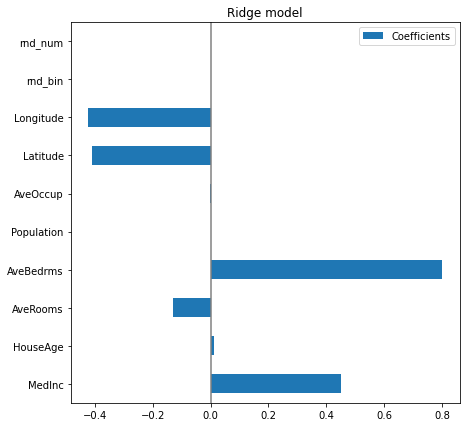

In [6]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)


### Sign of coefficients

```{admonition} A surprising association?
**Why is the coefficient associated to `AveRooms` negative?** Does the
price of houses decreases with the number of rooms?
```

The coefficients of a linear model are a *conditional* association:
they quantify the variation of a the output (the price) when the given
feature is varied, **keeping all other features constant**. We should
not interpret them as a *marginal* association, characterizing the link
between the two quantities ignoring all the rest.

The coefficient associated to `AveRooms` is negative because the number
of rooms is strongly correlated with the number of bedrooms,
`AveBedrms`. What we are seeing here is that for districts where the houses
have the same number of bedrooms on average, when there are more rooms
(hence non-bedroom rooms), the houses are worth comparatively less.

### Scale of coefficients

The `AveBedrms` have the higher coefficient. However, we can't compare the
magnitude of these coefficients directly, since they are not scaled. Indeed,
`Population` is an integer which can be thousands, while `AveBedrms` is
around 4 and Latitude is in degree.

So the Population coefficient is expressed in "$100k\$$ / habitant" while the
AveBedrms is expressed in "$100k\$$ / nb of bedrooms" and the Latitude
coefficient in "$100k\$$ / degree".

We see that changing population by one does not change the outcome, while as
we go south (latitude increase) the price becomes cheaper. Also, adding a
bedroom (keeping all other feature constant) shall rise the price of the
house by 80k$.

So looking at the coefficient plot to gauge feature importance can be
misleading as some of them vary on a small scale, while others vary a lot
more, several decades.

This becomes visible if we compare the standard deviations of our different
features.

(0.0, 100.0)

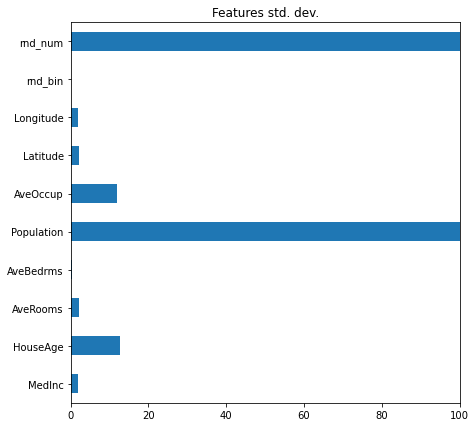

In [7]:
X_train.std(axis=0).plot(kind='barh', figsize=(9, 7))
plt.title('Features std. dev.')
plt.subplots_adjust(left=.3)
plt.xlim((0, 100))

So before any interpretation, we need to scale each column (removing the mean
and scaling the variance to 1).

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), RidgeCV())

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.6079822261145092
model score on testing data: 0.6015989882630668


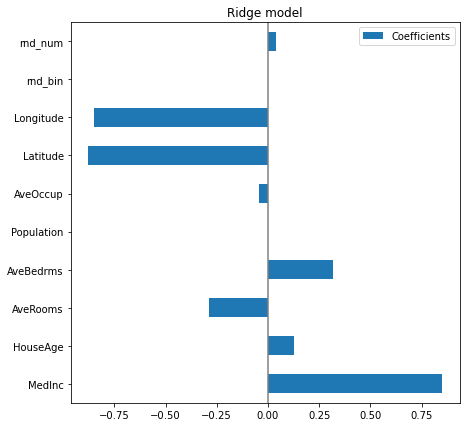

In [9]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Now that the coefficients have been scaled, we can safely compare them.

The median income feature, with longitude and latitude are the three
variables that most influence the model.

The plot above tells us about dependencies between a specific feature and the
target when all other features remain constant, i.e., conditional
dependencies. An increase of the `HouseAge` will induce an increase of the
price when all other features remain constant. On the contrary, an increase
of the average rooms will induce an decrease of the price when all other
features remain constant.

### Checking the variability of the coefficients

We can check the coefficient variability through cross-validation: it is a
form of data perturbation.

If coefficients vary significantly when changing the input dataset their
robustness is not guaranteed, and they should probably be interpreted with
caution.

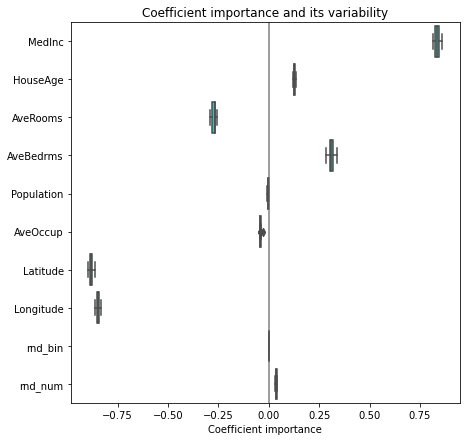

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
   model, X_with_rnd_feat, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
   return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
   [model[1].coef_
    for model in cv_model['estimator']],
   columns=X_with_rnd_feat.columns
)
plt.figure(figsize=(9, 7))
#sns.boxplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

Every coefficient looks pretty stable, which mean that different Ridge model
put almost the same weight to the same feature.

### Linear models with sparse coefficients (Lasso)

In order to illustrate that associations extracted depend on the
models, we consider feature selection with a L1 penalty. Let us fit a Lasso
model with a strong regularization parameters `alpha`

In [11]:
from sklearn.linear_model import Lasso

model = make_pipeline(StandardScaler(), Lasso(alpha=.03))

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.5763890661962305
model score on testing data: 0.5889171161357427


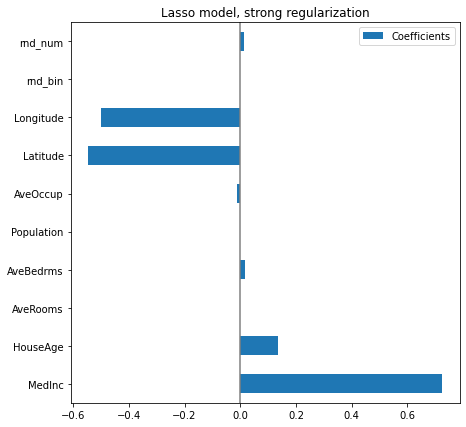

In [12]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Lasso model, strong regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Here the model score is a bit lower, because of the strong regularization.
However, it has selectioned only 5 non negative coefficients to make its
prediction.

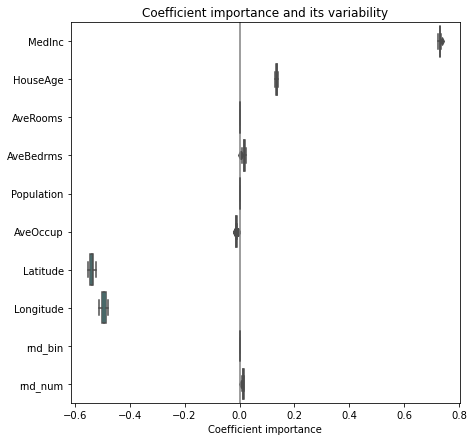

In [13]:
cv_model = cross_validate(
   model, X_with_rnd_feat, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
   return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
   [model[1].coef_
    for model in cv_model['estimator']],
   columns=X_with_rnd_feat.columns
)
plt.figure(figsize=(9, 7))
#sns.boxplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

### Lessons learned

Coefficients must be scaled to the same unit of measure to retrieve feature
importance, or comparing them.

Coefficients in multivariate linear models represent the dependency between a
given feature and the target, conditional on the other features.

Correlated features might induce instabilities in the coefficients of linear
models and their effects cannot be well teased apart.

Inspecting coefficients across the folds of a cross-validation loop gives an
idea of their stability.

## 2. RandomForest `feature_importances_`

On some algorithms, there pre-exist some feature importance method,
inherently built within the model. It is the case in RandomForest models.
Let's investigate the built-in `feature_importances_` attribute.

In [14]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.9745348043590877
model score on testing data: 0.8189513683491875


Contrary to the testing set, the score on the training set is almost perfect,
which means that our model is overfitting here.

In [15]:
importances = model.feature_importances_

The importance of a feature is basically: how much this feature is used in
each tree of the forest. Formally, it is computed as the (normalized) total
reduction of the criterion brought by that feature.

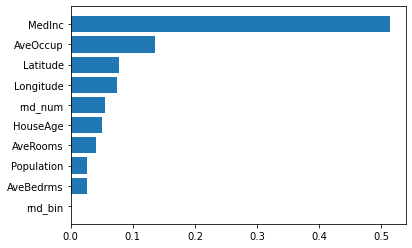

In [16]:
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

Median income is still the most important feature.

It also has a small bias toward high cardinality features, such as the noisy
feature `rnd_num`, which are here predicted having .07 importance, more than
`HouseAge` (which has low cardinality).

## 3. Feature importance by permutation

We introduce here a new technique to evaluate the feature importance of any
given fitted model. It basically shuffles a feature and sees how the model
changes its prediction. Thus, the change in prediction will be correspond to
the feature importance.

In [17]:
# Any model could be used here

model = RandomForestRegressor()
# model = make_pipeline(StandardScaler(),
#                       RidgeCV())

In [18]:
model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.9746121775609322
model score on testing data: 0.8199911986348215


The score on the test set is .81, so feature importance shall be relevant
here for this model.

### Feature importance

Lets compute the feature importance for a given feature, say the `MedInc`
feature.

For that, we will shuffle this specific feature, keeping the other feature as
is, and run our same model (already fitted) to predict the outcome. The
decrease of the score shall indicate how the model had used this feature to
predict the target. The permutation feature importance is defined to be the
decrease in a model score when a single feature value is randomly shuffled

For instance, if the feature is crucial for the model, the outcome would also
be permuted (just as the feature), thus the score would be close to zero.
Afterward, the feature importance is the decrease in score. So in that case,
the feature importance would be close to the score.

On the contrary, if the feature is not used by the model, the score shall
remain the same, thus the feature importance will be close to 0.

In [19]:
def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)

    permuted_score = model.score(X_permuted, y)
    return permuted_score


def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance


curr_feat = 'MedInc'

feature_importance = get_feature_importance(model, X_train, y_train, curr_feat)
print(f'feature importance of "{curr_feat}" on train set is '
      f'{feature_importance:.3}')

feature importance of "MedInc" on train set is 0.827


Since there are some randomness, it is advice to run multiple times and
inspect the mean and the standard deviation of the feature importance

In [20]:
n_repeats = 10

list_feature_importance = []
for n_round in range(n_repeats):
    list_feature_importance.append(
        get_feature_importance(model, X_train, y_train, curr_feat))

print(
    f'feature importance of "{curr_feat}" on train set is '
    f'{np.mean(list_feature_importance):.3} '
    f'+/- {np.std(list_feature_importance):.3}')

feature importance of "MedInc" on train set is 0.832 +/- 0.00869


0.86 over .97 is very relevant (note the $R^2$ score could go below 0). So we
can imagine our model relies heavily on this feature to predict the class.
We can now compute the feature permutation importance for all the features

In [21]:
def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

# This function could directly be access from sklearn
# from sklearn.inspection import permutation_importance

In [22]:
def plot_importantes_features(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

Let's compute the feature importance by permutation on the training data.

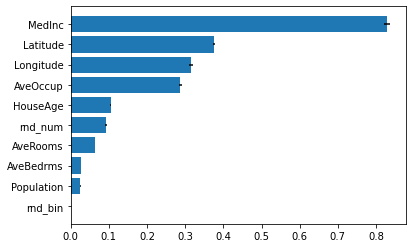

In [23]:
perm_importance_result_train = permutation_importance(
    model, X_train, y_train, n_repeats=10)

plot_importantes_features(perm_importance_result_train, X_train.columns)

We see again that the feature `MedInc`, `Latitude` and `Longitude` are very
important for the model.

We note that our random variable `rnd_num` is now very less important than
latitude. Indeed, the feature importance build-in in RandomForest has bias
for continuous data, such as `AveOccup` and `rnd_num`.

However, the model still uses these `rnd_num` feature to compute the output.
It is in line with the overfitting we had noticed between the train and test
score.

### discussion

1. For correlated feature, the permutation could give non realistic sample
   (e.g. nb of bedrooms higher than the number of rooms)
2. It is unclear whether you should use training or testing data to compute
   the feature importance.
3. Note that dropping a column and fitting a new model will not allow to
   analyse the feature importance for a specific model, since a *new* model
   will be fitted.

# Take Away



* One could directly interpret the coefficient in linear model (if the
  feature have been scaled first)
* Model like RandomForest have built-in feature importance
* `permutation_importance` gives feature importance by permutation for any
  fitted model